# Adversarial-Robustness-Toolbox for scikit-learn Support Vector Machines SVC and LinearSVC

In [1]:
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import load_iris

import numpy as np
from matplotlib import pyplot as plt

# from art.estimators.classification import SklearnClassifier, ScikitlearnSVC
from typing import Callable, List, Optional, Tuple, Union, TYPE_CHECKING
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import DeepFool
from art.attacks.evasion import CarliniL2Method
from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
class CustomRbfSVM(ScikitlearnSVC):
    def __init__(
        self,
        model: Union["sklearn.svm.SVC", "sklearn.svm.LinearSVC"],
        clip_values: Optional["CLIP_VALUES_TYPE"] = None,
        preprocessing_defences: Union["Preprocessor", List["Preprocessor"], None] = None,
        postprocessing_defences: Union["Postprocessor", List["Postprocessor"], None] = None,
        preprocessing: "PREPROCESSING_TYPE" = (0, 1),
    ) -> None:
        
        super().__init__(
            model=model,
            clip_values=clip_values,
            preprocessing_defences=preprocessing_defences,
            postprocessing_defences=postprocessing_defences,
            preprocessing=preprocessing,
        )
        
    def _kernel_grad(self, sv: np.ndarray, x_sample: np.ndarray) -> np.ndarray:
        """
        Applies the kernel gradient to a support vector.

        :param sv: A support vector.
        :param x_sample: The sample the gradient is taken with respect to.
        :return: the kernel gradient.
        """
        # pylint: disable=W0212
        if self.model.kernel == "linear":
            grad = sv
        elif self.model.kernel == "poly":
            grad = (
                self.model.degree
                * (self.model._gamma * np.sum(x_sample * sv) + self.model.coef0) ** (self.model.degree - 1)
                * sv
            )
        elif self.model.kernel == "rbf":
            grad = (
                2
                * self.model._gamma
                * (-1)
                * np.exp(-self.model._gamma * np.linalg.norm(x_sample - sv, ord=2) ** 2)
                * (x_sample - sv)
            )
        elif self.model.kernel == "sigmoid":
            raise NotImplementedError
        else:
            raise NotImplementedError("Loss gradients for kernel '{}' are not implemented.".format(self.model.kernel))
        return grad

## 1 Training scikit-learn SVC/LinearSVC and attacking with ART Projected Gradient Descent, CarliniL2Method, Deepfool 

In [3]:
def get_adversarial_examples(x_train, y_train, kernel, model_type=None, attack='PGD', use_fixed_rbf_grad=False):
    
    # Create and fit LinearSVC or SVC
    if model_type == 'LinearSVC':
        model = LinearSVC()
    else:
        model = SVC(C=1.0, kernel=kernel, degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=True, 
                    tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, 
                    decision_function_shape='ovr', random_state=None)
    model.fit(X=x_train, y=y_train)

    #  Create ART classfier for scikit-learn SVC
    if kernel == "rbf" and use_fixed_rbf_grad:
        art_classifier = CustomRbfSVM(model=model, clip_values=(0, 10))
    else:
        art_classifier = ScikitlearnSVC(model=model, clip_values=(0, 10))

    # Create ART attack
    if attack == 'PGD':
        attacker = ProjectedGradientDescent(estimator=art_classifier, norm=1, eps=1.0, eps_step=0.1,
                                            max_iter=10, targeted=False, num_random_init=0, batch_size=1)
    elif attack == 'CW':
        attacker = CarliniL2Method(classifier=art_classifier, max_iter=20)
    else:
        attacker = DeepFool(classifier=art_classifier, max_iter=5, epsilon=1e-6, nb_grads=3, batch_size=1)
            
    # Generate adversarial samples 
    x_train_adv = attacker.generate(x_train)

    return x_train_adv, model
    return 0, 0

## 1.1 Utility functions

In [4]:
def get_data(num_classes):
    x_train, y_train = load_iris(return_X_y=True)
    x_train = x_train[y_train < num_classes][:, [0, 1]]
    y_train = y_train[y_train < num_classes]
    x_train[:, 0][y_train == 0] -= 2
    x_train[:, 1][y_train == 2] += 2
    return x_train, y_train

In [5]:
def plot_results(model, x_train, y_train, x_train_adv, num_classes, model_type=None):
    
    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 5, 5))

    colors = ['orange', 'blue', 'green']

    for i_class in range(num_classes):

        # Plot difference vectors
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            axs[i_class].plot([x_1_0, x_2_0], [x_1_1, x_2_1], c='black', zorder=1)

        # Plot benign samples
        for i_class_2 in range(num_classes):
            axs[i_class].scatter(x_train[y_train == i_class_2][:, 0], x_train[y_train == i_class_2][:, 1], s=20,
                                 zorder=2, c=colors[i_class_2])
        axs[i_class].set_aspect('equal', adjustable='box')

        if model_type is None:
            # Mark support vectors with circles
            for sv in model.support_vectors_:
                axs[i_class].scatter(sv[0], sv[1], s=200, linewidth=3, facecolors='none', edgecolors='lightgreen',
                                     zorder=2)

        # Show predicted probability as contour plot
        h = .01
        x_min, x_max = 1.5, 8.5
        y_min, y_max = 0, 7

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        if model_type is None and model.probability:
            Z_proba = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
            Z_proba = Z_proba[:, i_class].reshape(xx.shape)
            im = axs[i_class].contourf(xx, yy, Z_proba, levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                       vmin=0, vmax=1)
            if i_class == num_classes - 1:
                cax = fig.add_axes([0.95, 0.2, 0.025, 0.6])
                plt.colorbar(im, ax=axs[i_class], cax=cax)
        else:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            axs[i_class].contour(xx, yy, Z, cmap=plt.cm.Paired)

        # Plot adversarial samples
        axs[i_class].scatter(x_train_adv[y_train == i_class][:, 0], x_train_adv[y_train == i_class][:, 1], zorder=2,
                             c='red', marker='X')
        axs[i_class].set_xlim((x_min, x_max))
        axs[i_class].set_ylim((y_min, y_max))

        axs[i_class].set_title('class ' + str(i_class))
        axs[i_class].set_xlabel('feature 1')
        axs[i_class].set_ylabel('feature 2')


# 2 Example: Iris dataset

### legend
- colored background: probability of class i
- orange circles: class 1
- blue circles: class 2
- green circles: class 3
- light green circles: support vectors
- red crosses: adversarial samples for class i

## 2.13 SVC, rbf kernel, binary classification with Projected Gradient Descent

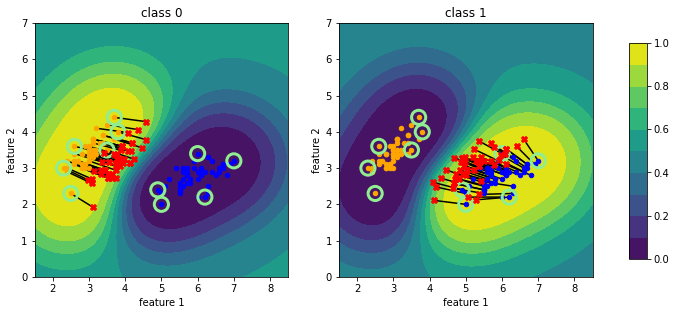

In [6]:
num_classes = 2
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='rbf')
plot_results(model, x_train, y_train, x_train_adv, num_classes)

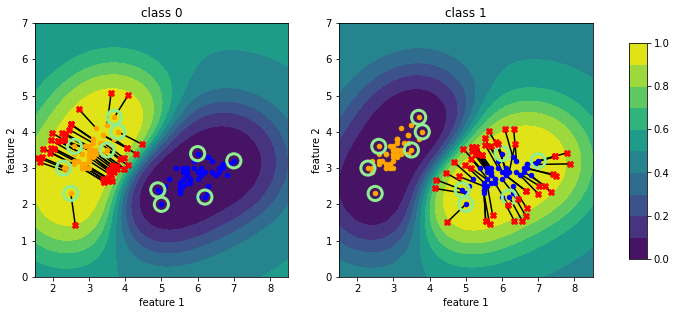

In [8]:
num_classes = 2
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='rbf', use_fixed_rbf_grad=True)
plot_results(model, x_train, y_train, x_train_adv, num_classes)

## 2.14 SVC, rbf kernel, binary classification with CarliniL2Method 

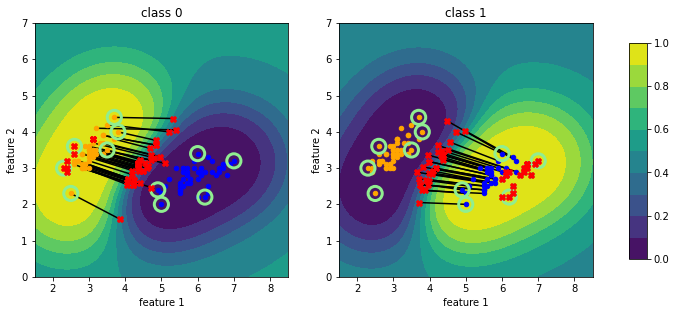

In [38]:
num_classes = 2
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='rbf', attack='CW')
plot_results(model, x_train, y_train, x_train_adv, num_classes)

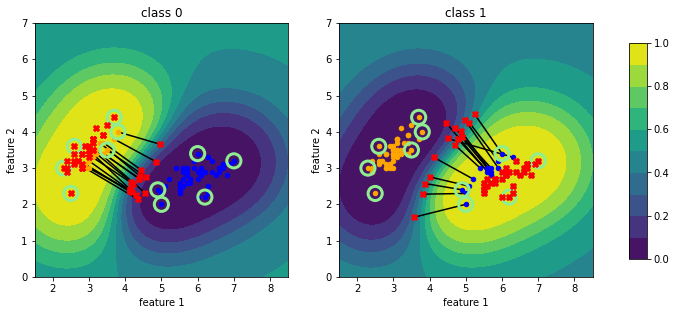

In [39]:
num_classes = 2
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='rbf', attack='CW', use_fixed_rbf_grad=True)
plot_results(model, x_train, y_train, x_train_adv, num_classes)

## 2.15 SVC, rbf kernel, binary classification with Deepfool

In [ ]:
num_classes = 2
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='rbf', attack='DF')
plot_results(model, x_train, y_train, x_train_adv, num_classes)

## 2.16 SVC, rbf kernel, multi-classification with Projected Gradient Descent 

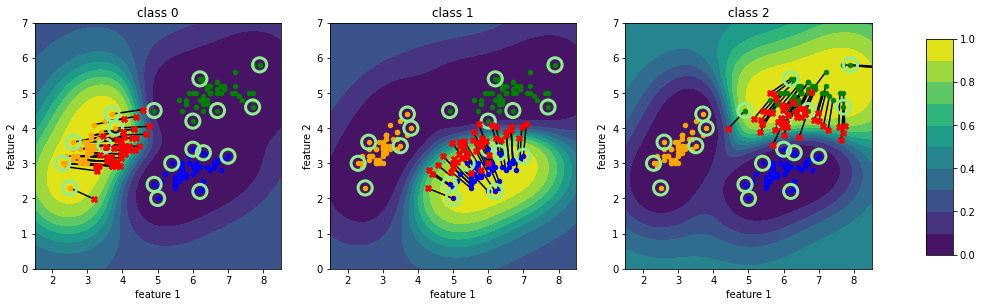

In [11]:
num_classes = 3
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='rbf')
plot_results(model, x_train, y_train, x_train_adv, num_classes)

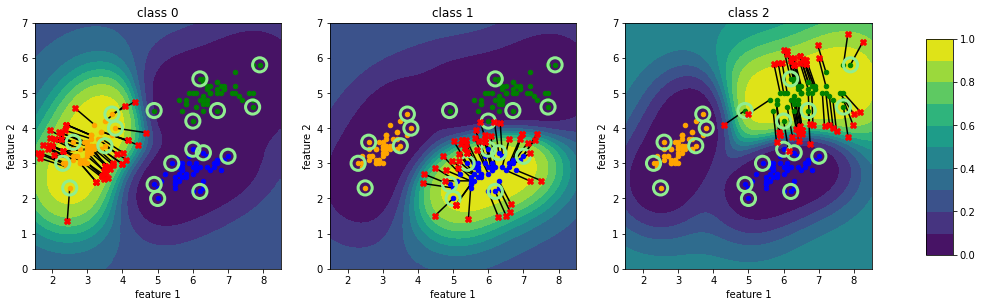

In [12]:
num_classes = 3
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='rbf', use_fixed_rbf_grad=True)
plot_results(model, x_train, y_train, x_train_adv, num_classes)

## 2.17 SVC, rbf kernel, multi-classification with CarliniL2Method

In [ ]:
num_classes = 3
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='rbf', attack='CW')
plot_results(model, x_train, y_train, x_train_adv, num_classes)

## 2.18 SVC, rbf kernel, multi-classification with Deepfool

In [ ]:
num_classes = 3
x_train, y_train = get_data(num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train, kernel='rbf', attack='DF')
plot_results(model, x_train, y_train, x_train_adv, num_classes)

# 3 Example: MNIST

## 3.1 Load and transform MNIST dataset

In [13]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

n_samples_train = x_train.shape[0]
n_features_train = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
n_samples_test = x_test.shape[0]
n_features_test = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]

x_train = x_train.reshape(n_samples_train, n_features_train)
x_test = x_test.reshape(n_samples_test, n_features_test)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

n_samples_max = 200
x_train = x_train[0:n_samples_max]
y_train = y_train[0:n_samples_max]
x_test = x_test[0:n_samples_max]
y_test = y_test[0:n_samples_max]

## 3.2 Train SVC classifier

In [14]:
model = SVC(C=1.0, kernel='rbf', probability=True)

In [15]:
model.fit(X=x_train, y=y_train)

SVC(probability=True)

## 3.3 Create and apply ProjectedGradientDescent Attack with ART

In [17]:
art_classifier = ScikitlearnSVC(model=model)

In [18]:
pgd = ProjectedGradientDescent(estimator=art_classifier, norm=np.inf, eps=.2, eps_step=0.1, max_iter=2, 
                               targeted=False, num_random_init=0, batch_size=128)

In [19]:
x_train_adv = pgd.generate(x_train)

In [20]:
x_test_adv = pgd.generate(x_test)

## 3.4 Evaluate SVC classifier on benign and adversarial samples

In [21]:
score = model.score(x_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 0.9900


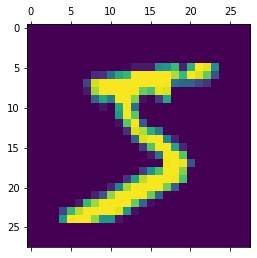

In [22]:
plt.matshow(x_train[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [23]:
prediction = model.predict(x_train[0:1, :])[0]
print("Benign Training Predicted Label: %i" % prediction)

Benign Training Predicted Label: 5


In [24]:
score = model.score(x_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

Adversarial Training Score: 0.6600


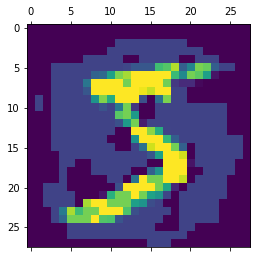

In [25]:
plt.matshow(x_train_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [26]:
prediction = model.predict(x_train_adv[0:1, :])[0]
print("Adversarial Training Predicted Label: %i" % prediction)

Adversarial Training Predicted Label: 3


In [27]:
score = model.score(x_test, y_test)
print("Benign Test Score: %.4f" % score)

Benign Test Score: 0.7450


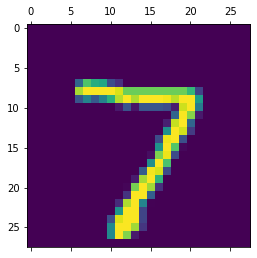

In [28]:
plt.matshow(x_test[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [29]:
prediction = model.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 7


In [30]:
score = model.score(x_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.2200


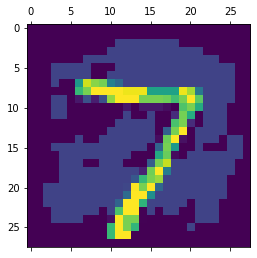

In [31]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [32]:
prediction = model.predict(x_test_adv[0:1, :])[0]
print("Adversarial Test Predicted Label: %i" % prediction)

Adversarial Test Predicted Label: 2


## 3.5 Investigate dependence on attack budget eps

(0.0, 1.0)

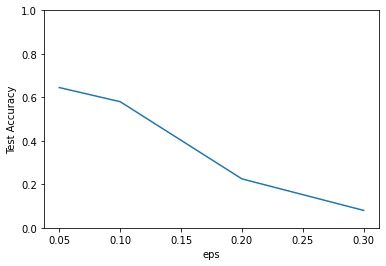

In [33]:
eps_list = [0.05, 0.1, 0.2, 0.3]
score_list = list()

for eps in eps_list:
    pgd = ProjectedGradientDescent(estimator=art_classifier, norm=np.inf, eps=eps, eps_step=0.01, max_iter=60, 
                                   targeted=False, num_random_init=0, batch_size=128)
    x_test_adv = pgd.generate(x_test)
    score = model.score(x_test_adv, y_test)
    score_list.append(score)

plt.plot(eps_list, score_list)
plt.xlabel('eps')
plt.ylabel('Test Accuracy')
plt.ylim((0, 1))

## 3.6 Targeted PGD attack

In [34]:
pgd = ProjectedGradientDescent(estimator=art_classifier, norm=np.inf, eps=0.5, eps_step=0.01, max_iter=20, 
                               targeted=True, num_random_init=3, batch_size=128)
y_test_target = np.zeros((y_test.shape[0], 10))
target_label = 7
y_test_target[:, target_label] = 1
x_test_adv = pgd.generate(x_test, y=y_test_target)
score = model.score(x_test_adv, y_test)

In [35]:
score = model.score(x_test_adv, np.argmax(y_test_target, axis=1))
print("Targeted Benign Test Score: %.4f" % score)

Targeted Benign Test Score: 0.4800


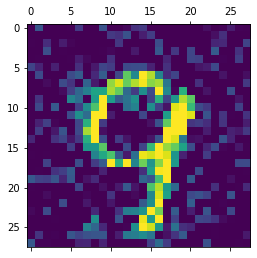

In [36]:
plt.matshow(x_test_adv[16, :].reshape((28, 28)))
plt.clim(0, 1)

In [37]:
prediction = model.predict(x_test_adv[16:17, :])[0]
print("Target Label: %i" % target_label)
print("Predicted Label: %i" % prediction)

Target Label: 7
Predicted Label: 7
